<span style="color:darkolivegreen;font-weight:800;font-size:32px">
    Building Agentic Apps: ArangoDB, NVIDIA cuGraph, and NetworkX Hackathon
</span>

<br>

<p align="center">
    <img src="https://arangodb.com/wp-content/uploads/2016/05/ArangoDB_logo_avocado_@1.png" style="height: 50px;">
    <img src="https://www.nvidia.com/content/dam/en-zz/Solutions/about-nvidia/logo-and-brand/02-nvidia-logo-color-grn-500x200-4c25-p@2x.png" style="height: 50px;">
    <img src="https://rapids.ai/images/RAPIDS-logo.png" style="height: 50px;">
    <img src="https://avatars.githubusercontent.com/u/388785?s=200&v=4" style="height: 50px;">
</p>

### **Step 0**: Package Installation and Setup

In [1]:
# 1. Install all requirements via pip

# !pip install -r requirements.txt

In [2]:
# 2. Check if you have an NVIDIA GPU
# Note: If this returns "command not found", then GPU-based algorithms via cuGraph are unavailable

# !nvidia-smi
# !nvcc --version

In [3]:
# 3. Install nx-cugraph via pip, requires CUDA-capable GPU
# Note: Only enable this installation if the step above is working!

# !pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com

In [4]:
# 4. Import the required modules

import os
import re
import json
import torch
import numpy as np
import pandas as pd
import networkx as nx
from typing import Dict
from typing import List
import nx_arangodb as nxadb
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import islice
from dotenv import load_dotenv
from arango import ArangoClient
from IPython.display import Markdown
from deep_translator import GoogleTranslator

from text_template import AQL_EXAMPLES
from text_template import SYSTEM_PROMPT
from text_template import AQL_QA_TEMPLATE

from adbnx_adapter.typings import NxId
from adbnx_adapter.typings import NxData
from adbnx_adapter import ADBNX_Adapter
from adbnx_adapter import ADBNX_Controller

from pydantic.v1 import Field
from pydantic.v1 import BaseModel

from sentence_transformers import util
from sentence_transformers import SentenceTransformer

from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langchain.prompts import PromptTemplate
from langgraph.prebuilt import create_react_agent
from langchain_community.graphs import ArangoGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain

load_dotenv(".env")
device = "cuda" if torch.cuda.is_available() else "cpu"

[07:42:39 +0700] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


### **Step 1**: Prepare and Load Dataset for `NetworkX`

In [5]:
def list_of_dict_to_json(data: list[dict], output_path: str) -> None:
    if not output_path.endswith(".json"):
        output_path = f"{output_path}.json"

    with open(output_path, "w", encoding="utf-8") as output_file:
        json.dump(data, output_file, indent=4)


def load_dataset_from_dir(dir_path: str) -> dict[str, pd.DataFrame]:
    json_data = {}
    json_files = sorted([file for file in os.listdir(dir_path) if file.endswith(".json")], reverse=True)
    
    for json_file in json_files:
        with open(os.path.join(dir_path, json_file), "r", encoding="utf-8") as file:
            json_data[os.path.splitext(json_file)[0]] = json.load(file)
    
    return json_data


def prepare_regulation_data(regulation_data: list[dict], output_dir: str, device: str, verbose: bool = True) -> None:
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
    result = {
    # Node
        "node_Regulation": [],
        "node_Consideration": [],
        "node_Observation": [],
        "node_Article": [],
        "node_Definition": [],
    # Relationship
        "edge_reg_AMENDED_BY": [],
        "edge_HAS_CONSIDERATION": [],
        "edge_HAS_OBSERVATION": [],
        "edge_HAS_DEFINITION": [],
        "edge_HAS_ARTICLE": [],
        "edge_NEXT_ARTICLE": [],
        "edge_REFER_TO": [],
        "edge_art_AMENDED_BY": [],
    }

    edge_NEXT_ARTICLE_1 = []
    edge_NEXT_ARTICLE_2 = []

    for regulation in tqdm(iterable=regulation_data, desc="Transform regulation data", disable=not verbose):
        result["node_Regulation"].append({
            "id": int(regulation["id"]),
            "title": regulation["title"],
            "about": regulation["about"],
            "type": regulation["short_type"],
            "number": int(regulation["number"]),
            "year": int(regulation["year"]),
            "is_amendment": bool(int(regulation["amendment"])),
            # "amendment_order": int(regulation["amendment"]),
            "institution": regulation["institution"],
            "issue_place": regulation["issue_place"],
            "issue_date": regulation["issue_date"] if regulation["issue_date"] else None,
            "effective_date": regulation["effective_date"] if regulation["effective_date"] else None,
            "subjects": regulation["subjects"],
            "reference_url": regulation["url"],
            "download_url": regulation["download_link"],
            "download_name": regulation["download_name"]
        })

        for amended_regulation in regulation["status"]["amend"]:
            if re.search(r"peraturan\.bpk\.go\.id", amended_regulation, re.IGNORECASE) is None:
                result["edge_reg_AMENDED_BY"].append({
                    "from_type": "Regulation",
                    "from": int(amended_regulation),
                    "to_type": "Regulation",
                    "to": int(regulation["id"]),
                    "amendment_number": int(regulation["amendment"])
                })

        for key, content in regulation["content"].items():
            if key == "considering":
                result["node_Consideration"].append({
                    "id": int(content["id"]),
                    "text": content["text"],
                    "embedding": embedding_model.encode(content["text"]).tolist()
                })

                result["edge_HAS_CONSIDERATION"].append({
                    "from_type": "Regulation",
                    "from": int(regulation["id"]),
                    "to_type": "Consideration",
                    "to": int(content["id"])
                })

            elif key == "observing":
                result["node_Observation"].append({
                    "id": int(content["id"]),
                    "text": content["text"],
                    "embedding": embedding_model.encode(content["text"]).tolist()

                })

                result["edge_HAS_OBSERVATION"].append({
                    "from_type": "Regulation",
                    "from": int(regulation["id"]),
                    "to_type": "Observation",
                    "to": int(content["id"])
                })

            elif key == "articles":
                for article in content.values():
                    text = (
                        f"{regulation['title']}, "
                        f"{(article['chapter_about'] or '') + ', ' if article['chapter_about'] else ''}"
                        f"{(article['part_about'] or '') + ', ' if article['part_about'] else ''}"
                        f"{(article['paragraph_about'] or '') + ', ' if article['paragraph_about'] else ''}"
                        f"Pasal {article['article_number']}:\n"
                        f"{article['text']}".strip()
                    )

                    result["node_Article"].append({
                        "id": int(article["id"]),
                        "number": article["article_number"],
                        "chapter": article["chapter_number"] if article["chapter_number"] else None,
                        "part": article["part_number"] if article["part_number"] else None,
                        "paragraph": article["paragraph_number"] if article["paragraph_number"] else None,
                        "text": text,
                        "embedding": embedding_model.encode(text).tolist()
                    })

                    result["edge_HAS_ARTICLE"].append({
                        "from_type": "Regulation",
                        "from": int(regulation["id"]),
                        "to_type": "Article",
                        "to": int(article["id"])
                    })

                    if article["previous_article"]:
                        edge_NEXT_ARTICLE_1.append((
                            int(article["previous_article"]),
                            int(article["id"]),
                            int(regulation["amendment"])
                        ))

                    if article["next_article"]:
                        edge_NEXT_ARTICLE_2.append((
                            int(article["id"]),
                            int(article["next_article"]),
                            int(regulation["amendment"])
                        ))

                    if article["references"]:
                        for reference_article_id in article["references"]:
                            result["edge_REFER_TO"].append({
                                "from_type": "Article",
                                "from": int(article["id"]),
                                "to_type": "Article",
                                "to": int(reference_article_id)
                            })

                    if article["amend"]:
                        for amended_article_id in article["amend"]:
                            result["edge_art_AMENDED_BY"].append({
                                "from_type": "Article",
                                "from": int(amended_article_id),
                                "to_type": "Article",
                                "to": int(article["id"])
                            })

            else:
                for definition in content:
                    text = (
                        f"{regulation['title']}, "
                        f"Definisi {definition['name']}:\n"
                        f"{definition['definition']}".strip()
                    )

                    result["node_Definition"].append({
                        "id": int(definition["id"]),
                        "name": definition["name"],
                        "text": text,
                        "embedding": embedding_model.encode(text).tolist()
                    })

                    result["edge_HAS_DEFINITION"].append({
                        "from_type": "Regulation",
                        "from": int(regulation["id"]),
                        "to_type": "Definition",
                        "to": int(definition["id"])
                    })

    for edge in sorted(set(edge_NEXT_ARTICLE_1 + edge_NEXT_ARTICLE_2)):
        result["edge_NEXT_ARTICLE"].append({
            "from_type": "Article",
            "from": edge[0],
            "to_type": "Article",
            "to": edge[1],
            "amendment_number": edge[2]
        })

    for key, value in tqdm(iterable=result.items(), desc="Save transformed data to JSON", disable=not verbose):
        list_of_dict_to_json(data=value, output_path=os.path.join(output_dir, f"{key}.json"))

In [6]:
# 1. Prepare dataset from initial JSON file (transform and create text embedding)

json_raw_input = os.path.join("data", "raw", "raw.json")
with open(json_raw_input) as file:
    json_data = json.load(file)

prepare_regulation_data(
    regulation_data=json_data,
    output_dir="data",
    device=device,
    verbose=True
)

Save transformed data to JSON: 100%|██████████| 13/13 [00:02<00:00,  5.62it/s]


In [7]:
# 2. Load dataset from prepared JSON file

dataset = load_dataset_from_dir("data")

print(f"{'Dataset':<25}: {len(dataset):>5}  Entity")
for index, data in enumerate(dataset.items()):
    key, value = data
    print_value = f"{key:<25}: {len(value):>5}  data {type(value)} of {type(value[0])}"
    if index == 0: print("-" * len(print_value))
    print(print_value)

Dataset                  :    13  Entity
-----------------------------------------------------------------------
node_Regulation          :    63  data <class 'list'> of <class 'dict'>
node_Observation         :    63  data <class 'list'> of <class 'dict'>
node_Definition          :   957  data <class 'list'> of <class 'dict'>
node_Consideration       :    63  data <class 'list'> of <class 'dict'>
node_Article             :  2423  data <class 'list'> of <class 'dict'>
edge_reg_AMENDED_BY      :    26  data <class 'list'> of <class 'dict'>
edge_art_AMENDED_BY      :    83  data <class 'list'> of <class 'dict'>
edge_REFER_TO            :  1497  data <class 'list'> of <class 'dict'>
edge_NEXT_ARTICLE        :  2422  data <class 'list'> of <class 'dict'>
edge_HAS_OBSERVATION     :    63  data <class 'list'> of <class 'dict'>
edge_HAS_DEFINITION      :   957  data <class 'list'> of <class 'dict'>
edge_HAS_CONSIDERATION   :    63  data <class 'list'> of <class 'dict'>
edge_HAS_ARTICLE       

### **Step 2**: Convert and Load Graph Data into `NetworkX`

In [8]:
# 1. Crate empty multi directed graph

G = nx.MultiDiGraph()

In [9]:
# 2. Load node data into multi directed graph

for key, data in dataset.items():
    if key.startswith("node_"):
        label = re.search(r"node_(.*)", key, re.IGNORECASE)[1].lower()
        for row in data:
            node_id = f"{label}/{row['id']}"
            attributes = dict(islice(row.items(), 1, None))
            G.add_node(node_id, **attributes)

print(f"Total node: {G.number_of_nodes()}")

Total node: 3569


In [10]:
# 3. Load edge data into multi directed graph

for key, data in dataset.items():
    if key.startswith("edge_"):
        edge_type = re.search(r"([A-Z_]*)$", key)[1]
        edge_type = edge_type[1:].lower()
        for row in data:
            source_id = f"{row['from_type'].lower()}/{row['from']}"
            target_id = f"{row['to_type'].lower()}/{row['to']}"
            attributes = dict(islice(row.items(), 4, None))
            G.add_edge(source_id, target_id, type=edge_type, **attributes)

print(f"Total edge: {G.number_of_edges()}")

Total edge: 7534


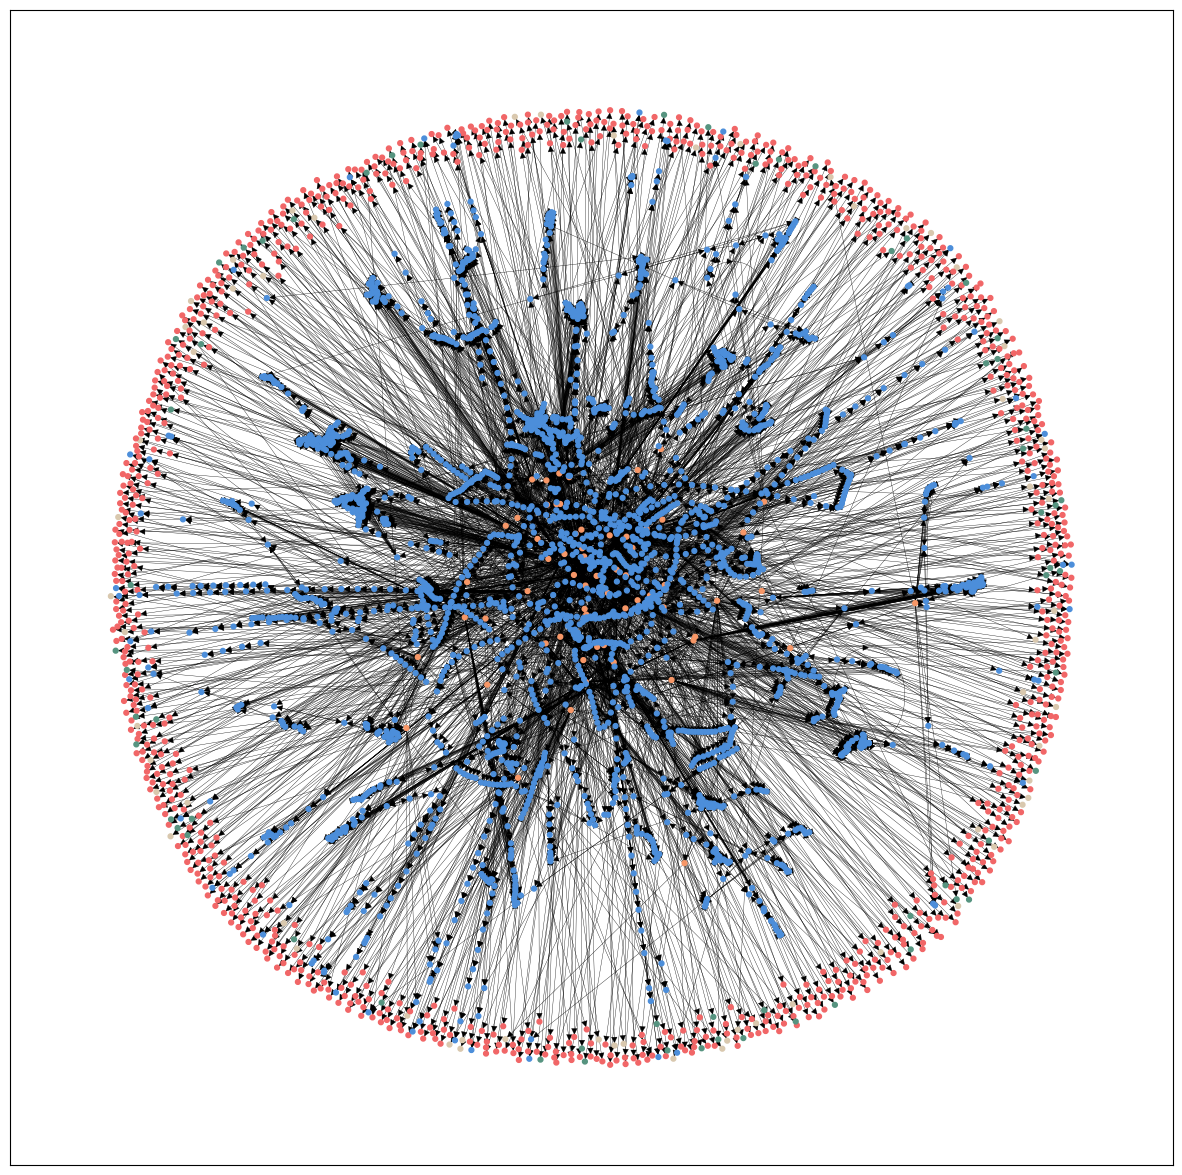

In [11]:
# 3. Visualize the Graph
# Reference: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html#visualizing-the-graph

label_colors = {
    "regulation": "#f79767",     # Orange
    "consideration": "#569480",  # Green
    "observation": "#d9c8ae",    # Cream
    "definition": "#f16667",     # Red
    "article": "#4c8eda"         # Blue
}

colors = []
for node, data in G.nodes(data=True):
    collection = re.search(r"^(.*)/\d+$", node)[1]
    color = label_colors[collection]
    colors.append(color)

plot_options = {"node_size": 12, "with_labels": False, "width": 0.25, "node_color": colors}
pos = nx.spring_layout(G, iterations=100, seed=42)
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### **Step 3**: Persist the Graph in ArangoDB

In [12]:
# 1. Connect to the ArangoDB database

db = ArangoClient(hosts=os.environ["DATABASE_HOST"]).db(
    name=os.environ["DATABASE_NAME"],
    username=os.environ["DATABASE_USERNAME"],
    password=os.environ["DATABASE_PASSWORD"],
    verify=True
)

print(db)

<StandardDatabase hackathon>


In [13]:
# 2. Create edge definitions and custom ADBNX controller

# Specify list of ArangoDB edge definitions
edge_definitions = [
    {
        "edge_collection": "amended_by",
        "from_vertex_collections": ["regulation", "article"],
        "to_vertex_collections": ["regulation", "article"],
    },
    {
        "edge_collection": "has_consideration",
        "from_vertex_collections": ["regulation"],
        "to_vertex_collections": ["consideration"],
    },
    {
        "edge_collection": "has_observation",
        "from_vertex_collections": ["regulation"],
        "to_vertex_collections": ["observation"],
    },
    {
        "edge_collection": "has_definition",
        "from_vertex_collections": ["regulation"],
        "to_vertex_collections": ["definition"],
    },
    {
        "edge_collection": "has_article",
        "from_vertex_collections": ["regulation"],
        "to_vertex_collections": ["article"],
    },
    {
        "edge_collection": "next_article",
        "from_vertex_collections": ["article"],
        "to_vertex_collections": ["article"],
    },
    {
        "edge_collection": "refer_to",
        "from_vertex_collections": ["article"],
        "to_vertex_collections": ["article"],
    }
]

# Create custom ADBNX Controller to handle node and edge transition from NetworkX to ArangoDB
# Reference: https://github.com/arangoml/networkx-adapter/blob/master/examples/outputs/ArangoDB_NetworkX_Adapter_output.ipynb
class Custom_ADBNX_Controller(ADBNX_Controller):
    """ArangoDB-NetworkX controller.

    Responsible for controlling how nodes & edges are handled when
    transitioning from ArangoDB to NetworkX, and vice-versa.
    """

    def _identify_networkx_node(
        self, nx_node_id: NxId, nx_node: NxData, adb_v_cols: List[str]
    ) -> str:
        """Given a NetworkX node, and a list of ArangoDB vertex collections defined,
        identify which ArangoDB vertex collection **nx_node** should belong to.

        NOTE: You must override this function if len(**adb_v_cols**) > 1.

        :param nx_node_id: The NetworkX ID of the node.
        :type nx_node_id: adbnx_adapter.typings.NxId
        :param nx_node: The NetworkX node object.
        :type nx_node: adbnx_adapter.typings.NxData
        :param adb_v_cols: All ArangoDB vertex collections specified
            by the **edge_definitions** parameter of networkx_to_arangodb()
        :type adb_v_cols: List[str]
        :return: The ArangoDB collection name
        :rtype: str
        """
        return str(nx_node_id).split("/")[0]  # Identify node based on '/' split


    def _identify_networkx_edge(
        self,
        nx_edge: NxData,
        from_node_id: NxId,
        to_node_id: NxId,
        nx_map: Dict[NxId, str],
        adb_e_cols: List[str],
    ) -> str:
        """Given a NetworkX edge, its pair of nodes, and a list of ArangoDB
        edge collections defined, identify which ArangoDB edge collection **nx_edge**
        should belong to.

        NOTE #1: You must override this function if len(**adb_e_cols**) > 1.

        :param nx_edge: The NetworkX edge object.
        :type nx_edge: adbnx_adapter.typings.NxData
        :param from_node_id: The NetworkX ID of the node representing the edge source.
        :type from_node_id: adbnx_adapter.typings.NxId
        :param to_node_id: The NetworkX ID of the node representing the edge destination.
        :type to_node_id: adbnx_adapter.typings.NxId
        :param nx_map: A mapping of NetworkX node ids to ArangoDB vertex ids. You
            can use this to derive the ArangoDB _from and _to values of the edge.
            i.e, `nx_map[from_node_id]` will give you the ArangoDB _from value,
            and `nx_map[to_node_id]` will give you the ArangoDB _to value.
        :type nx_map: Dict[NxId, str]
        :param adb_e_cols: All ArangoDB edge collections specified
            by the **edge_definitions** parameter of
            ADBNX_Adapter.networkx_to_arangodb()
        :type adb_e_cols: List[str]
        :return: The ArangoDB collection name
        :rtype: str
        """
        return nx_edge["type"]  # Identify edge based on "type" attribute
    

    def _keyify_networkx_node(
        self, i: int, nx_node_id: NxId, nx_node: NxData, col: str
    ) -> str:
        """Given a NetworkX node, derive its ArangoDB key.

        NOTE #1: You must override this function if you want to create custom ArangoDB
        _key values for your NetworkX nodes.

        NOTE #2: You are free to use `_string_to_arangodb_key_helper()` and
        `_tuple_to_arangodb_key_helper()` to derive a valid ArangoDB _key value.

        :param i: The index of the NetworkX node in the list of nodes.
        :type i: int
        :param nx_node_id: The NetworkX node id.
        :type nx_node_id: adbnx_adapter.typings.NxId
        :param nx_node: The NetworkX node object.
        :type nx_node: adbnx_adapter.typings.NxData
        :param col: The ArangoDB collection that **nx_node** belongs to.
        :type col: str
        :return: A valid ArangoDB _key value.
        :rtype: str
        """
        return str(nx_node_id).split("/")[1] # Keyify node based on '/' split

In [14]:
# 3. Instantiate the custom ADBNX using the DB and custom ADBNX controller

custom_adbnx_adapter = ADBNX_Adapter(db, Custom_ADBNX_Controller())

[2025/03/08 07:46:34 +0700] [12372] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'hackathon'


In [15]:
# 4. Load the NetworkX Graph into new ArangoDB graph

name = os.environ["GRAPH_NAME"]
db.delete_graph(name, drop_collections=True, ignore_missing=True)
G_adb = custom_adbnx_adapter.networkx_to_arangodb(name, G, edge_definitions, batch_size=128)
print(G_adb)

Output()

Output()

[2025/03/08 07:46:36 +0700] [12372] [INFO] - adbnx_adapter: Created ArangoDB 'hackathon' Graph


<Graph hackathon>


In [16]:
# 5. Re-connect to the same Graph using nxadb (required)

db = ArangoClient(hosts=os.environ["DATABASE_HOST"]).db(
    name=os.environ["DATABASE_NAME"],
    username=os.environ["DATABASE_USERNAME"],
    password=os.environ["DATABASE_PASSWORD"],
    verify=True
)

name = os.environ["GRAPH_NAME"]
G_adb = nxadb.MultiDiGraph(name=name, db=db)
print(G_adb)

[07:46:38 +0700] [INFO]: Graph 'hackathon' exists.
[07:46:38 +0700] [INFO]: Default node type set to 'article'


MultiDiGraph named 'hackathon' with 3569 nodes and 7534 edges


In [17]:
# 6. Modify the "effective" attribute in article nodes

# Set the "effective" attribute to True for all articles
result_1 = G_adb.query("""
    RETURN COUNT (
        FOR node IN article
            UPDATE node WITH { effective: true } IN article
            RETURN NEW
    )
""")

# Set the "effective" attribute to False for all articles that are "amended_by"
result_2 = G_adb.query("""
    RETURN COUNT(
        FOR node IN article
            FILTER node._id IN (
                FOR edge IN amended_by
                    RETURN edge._from
            )
            UPDATE node WITH { effective: false } IN article
            RETURN NEW
    )
""")

result_1 = list(result_1)[0]
result_2 = list(result_2)[0]
print(f"Number of effective article node   : {result_1 - result_2}")
print(f"Number of ineffective article node : {result_2}")

Number of effective article node   : 2352
Number of ineffective article node : 71


In [18]:
# 7. Modify the "effective" attribute in the next_article edges

# Set the "effective" attribute to True for all next_article edges
G_adb.query("""
    RETURN COUNT (
        FOR edge IN next_article
            UPDATE edge WITH { effective: true } IN next_article
            RETURN NEW
    )
""")

# Set the "effective" attribute to False for all next_article edges
# that point to an article node with an "effective" attribute set to False
G_adb.query("""
RETURN COUNT(
    FOR node IN article
        FILTER node.effective == false

        // Update edges dengan arah MASUK ke article yang effective-nya false
        FOR edge IN next_article
            FILTER edge._to == node._id
            UPDATE edge WITH { effective: false } IN next_article
            RETURN NEW
)
""")

# Set the "effective" attribute to False for all next_article edges
# that originate from an article node with an "effective" attribute set to False
G_adb.query("""
RETURN COUNT(
    FOR node IN article
        FILTER node.effective == false

        // Update edges dengan arah KELUAR dari article yang effective-nya false
        FOR edge IN next_article
            FILTER edge._from == node._id
            UPDATE edge WITH { effective: false } IN next_article
            RETURN NEW
)
""")

# For article nodes that have more than one outgoing next_article edge:
# - Set effective = True for the next_article edge with the highest amendment_number
# - Set effective = False for next_article edges with an amendment_number lower than the highest one
G_adb.query("""
    RETURN COUNT(
        FOR node IN article
            LET outgoing_edges = (
                FOR edge IN next_article
                    FILTER edge._from == node._id
                    RETURN { _id: edge._id, amendment_number: edge.amendment_number, edge: edge}
            )

            LET max_amendment_number = MAX(outgoing_edges[*].amendment_number)

            FOR edge_info IN outgoing_edges
                FILTER edge_info.amendment_number < max_amendment_number
                UPDATE edge_info.edge WITH { effective: false } IN next_article
                RETURN NEW
    )
""")

# Count the number of next_article edges that are effective
effective_next_article = G_adb.query("""
    RETURN COUNT(
        FOR edge in next_article
            FILTER edge.effective == true
            RETURN edge
    )
""")

# Count the number of next_article edges that are ineffective
ineffective_next_article = G_adb.query("""
    RETURN COUNT(
        FOR edge in next_article
            FILTER edge.effective == false
            RETURN edge
    )
""")

effective_next_article = list(effective_next_article)[0]
ineffective_next_article = list(ineffective_next_article)[0]

print(f"Number of effective next_article edge   : {effective_next_article}")
print(f"Number of ineffective next_article edge : {ineffective_next_article}")

Number of effective next_article edge   : 2303
Number of ineffective next_article edge : 119


In [19]:
# 8. Test: Print the degree of a Node

G_adb.degree("regulation/201005029100000")

23

In [20]:
# 9. Test: Query the Graph
# Reference: https://arangodb.com/sql-aql-comparison/

# Sample 1 nodes
result = G_adb.query("""
    FOR node IN regulation
        SORT RAND()
        LIMIT 1
        RETURN node
""")

display(list(result))
print("-"*10)

# Sample 1 nodes
result = G_adb.query("""
    FOR node IN article
        SORT RAND()
        LIMIT 1
        RETURN node
""")

# This process is just to prevent the embedding display from being too large
result = {k: (v[:5] if isinstance(v, list) else v) for k, v in list(result)[0].items()}
result["embedding"] += ["..."]
display(result)
print("-"*10)

# Sample 3 edges
result = G_adb.query("""
    FOR edge IN amended_by
        FILTER IS_SAME_COLLECTION("regulation", edge._from) 
        AND IS_SAME_COLLECTION("regulation", edge._to)
        SORT RAND()
        LIMIT 3
        RETURN edge
""")

display(list(result))
print("-"*10)

# Get all the embedding data
result = G_adb.query("""
    RETURN UNION(
        (FOR doc IN definition RETURN { _id: doc._id, embedding: doc.embedding }),
        (FOR doc IN article RETURN { _id: doc._id, embedding: doc.embedding }),
        (FOR doc IN consideration RETURN { _id: doc._id, embedding: doc.embedding }),
        (FOR doc IN observation RETURN { _id: doc._id, embedding: doc.embedding })
    )
""")

# This process is just to prevent the embedding display from being too large
result = {k: (v[:5] if isinstance(v, list) else v) for k, v in list(result)[0][0].items()}
result["embedding"] += ["..."]
display(result)

[{'_key': '202205016100000',
  '_id': 'regulation/202205016100000',
  '_rev': '_jVK14OS--n',
  'title': 'Peraturan Menteri Komunikasi dan Informatika Nomor 16 Tahun 2022 tentang Kebijakan Umum Penyelenggaraan Audit Teknologi Informasi dan Komunikasi',
  'about': 'Kebijakan Umum Penyelenggaraan Audit Teknologi Informasi dan Komunikasi',
  'type': 'PERMENKOMINFO',
  'number': 16,
  'year': 2022,
  'is_amendment': False,
  'institution': 'Kementerian Komunikasi dan Informatika',
  'issue_place': 'Jakarta',
  'issue_date': '2022-12-27',
  'effective_date': '2022-12-30',
  'subjects': ['TELEKOMUNIKASI, INFORMATIKA, SIBER, DAN INTERNET'],
  'reference_url': 'https://peraturan.bpk.go.id/Details/255601/permenkominfo-no-16-tahun-2022',
  'download_url': 'https://peraturan.bpk.go.id/Download/312289/2022permen16..pdf',
  'download_name': 'PERMENKOMINFO_2022_016'}]

----------


{'_key': '202405006601500',
 '_id': 'article/202405006601500',
 '_rev': '_jVK18bm--V',
 'number': '15',
 'chapter': '3',
 'part': '2',
 'paragraph': None,
 'text': 'Peraturan Menteri Komunikasi dan Informatika Nomor 6 Tahun 2024 tentang Tata Cara Seleksi Pengguna Pita Frekuensi Radio, BAB III - PERSIAPAN SELEKSI, Bagian Kedua - Objek Seleksi, Pasal 15:\n(1) Penetapan Objek Seleksi sebagaimana dimaksud dalam Pasal 12 huruf a paling sedikit memuat informasi mengenai:\n\ta. rentang Pita Frekuensi Radio;\n\tb. jumlah blok Pita Frekuensi Radio yang merupakan Objek Seleksi;\n\tc. mode frekuensi radio; dan\n\td. masa berlaku IPFR.\n(2) Penetapan Objek Seleksi sebagaimana dimaksud pada ayat (1) mempertimbangkan:\n\ta. ekosistem Pita Frekuensi Radio;\n\tb. guardband;\n\tc. optimalisasi penggunaan Pita Frekuensi Radio;\n\td. peminatan penyelenggara Telekomunikasi; dan\n\te. isu teknis lainnya.\n(3) Guardband sebagaimana dimaksud pada ayat (2) huruf b merupakan Pita Frekuensi Radio yang berfungsi

----------


[{'_key': '284',
  '_id': 'amended_by/284',
  '_from': 'regulation/201005029100000',
  '_to': 'regulation/201705005100000',
  '_rev': '_jVK15x2--C',
  'type': 'amended_by',
  'amendment_number': 4},
 {'_key': '1287',
  '_id': 'amended_by/1287',
  '_from': 'regulation/201905013100000',
  '_to': 'regulation/202105014100000',
  '_rev': '_jVK152m--A',
  'type': 'amended_by',
  'amendment_number': 3},
 {'_key': '1285',
  '_id': 'amended_by/1285',
  '_from': 'regulation/201905013100000',
  '_to': 'regulation/202005002100000',
  '_rev': '_jVK152m---',
  'type': 'amended_by',
  'amendment_number': 1}]

----------


{'_id': 'definition/200705011400100',
 'embedding': [0.007859768345952034,
  0.021319838240742683,
  -0.07860685884952545,
  -0.05002573877573013,
  -0.0654512569308281,
  '...']}

In [21]:
# 10. Test: Test node/edge calling

print("# NODE")
print(G_adb.nodes["regulation/200705011100000"])     # regulation node
print(G_adb.nodes["consideration/200705011200000"])  # consideration node
print(G_adb.nodes["observation/200705011300000"])    # observation node
print(G_adb.nodes["definition/201605004400200"])     # definition node

# article node (this process is just to prevent the embedding display from being too large)
article_node_example = G_adb.nodes["article/200705011600200"]
article_node_example = {k: (v[:5] if isinstance(v, list) else v) for k, v in article_node_example.items()}
article_node_example["embedding"] += ["..."]
print(article_node_example)
print("-" * 80)

print("# EDGE")
print(G_adb["regulation/200705011100000"]["regulation/200705038100000"])     # amended_by (regulation) edge
print(G_adb["regulation/200705011100000"]["consideration/200705011200000"])  # has_consideration edge
print(G_adb["regulation/200705011100000"]["observation/200705011300000"])    # has_observation edge
print(G_adb["regulation/201605004100000"]["definition/201605004400200"])     # has_definition edge
print(G_adb["regulation/200705011100000"]["article/200705011600100"])        # has_article edge
print(G_adb["article/199901036600100"]["article/199901036600200"])           # next_article edge
print(G_adb["article/200705011601600"]["article/200705011600300"])           # refer_to edge
print(G_adb["article/200705011601000"]["article/200705038601000"])           # amended_by (article) edge

# NODE
{'_key': '200705011100000', '_id': 'regulation/200705011100000', 'title': 'Peraturan Menteri Komunikasi dan Informatika Nomor 11/PER/M.KOMINFO/4/2007 Tahun 2007 tentang Penyediaan Kewajiban Pelayanan Universal Telekomunikasi', 'about': 'Penyediaan Kewajiban Pelayanan Universal Telekomunikasi', 'type': 'PERMENKOMINFO', 'number': 11, 'year': 2007, 'is_amendment': False, 'institution': 'Kementerian Komunikasi dan Informatika', 'issue_place': 'Jakarta', 'issue_date': '2007-04-13', 'effective_date': '2007-04-13', 'subjects': ['TELEKOMUNIKASI, INFORMATIKA, SIBER, DAN INTERNET', 'PERIZINAN, PELAYANAN PUBLIK'], 'reference_url': 'https://peraturan.bpk.go.id/Details/159911/permenkominfo-no-11permkominfo42007-tahun-200', 'download_url': 'https://peraturan.bpk.go.id/Download/152473/Permen%20Kominfo%20Nomor%2011%20Tahun%202007.pdf', 'download_name': 'PERMENKOMINFO_2007_011'}
{'_key': '200705011200000', '_id': 'consideration/200705011200000', 'text': 'a. bahwa telekomunikasi mempunyai peran y

### **Step 4**: Build the Agentic App with LangChain

In [22]:
# 1. Re-connect to the same Graph using nxadb
# You can start from this cell if you just want to try the agentic app

db = ArangoClient(hosts=os.environ["DATABASE_HOST"]).db(
    name=os.environ["DATABASE_NAME"],
    username=os.environ["DATABASE_USERNAME"],
    password=os.environ["DATABASE_PASSWORD"],
    verify=True
)

name = os.environ["GRAPH_NAME"]
G_adb = nxadb.MultiDiGraph(name=name, db=db)
print(G_adb)

[07:46:42 +0700] [INFO]: Graph 'hackathon' exists.
[07:46:42 +0700] [INFO]: Default node type set to 'article'


MultiDiGraph named 'hackathon' with 3569 nodes and 7534 edges


In [23]:
# 2. Create the ArangoGraph LangChain wrapper
# Reference: https://api.python.langchain.com/en/latest/graphs/langchain_community.graphs.arangodb_graph.ArangoGraph.html

arango_graph = ArangoGraph(db)

In [24]:
# 3. Defiine and test the LLM object

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.0,
    api_key=os.environ["GOOGLE_API_KEY"]
)

llm.invoke("hello! who are you?").content

'I am a large language model, trained by Google.\n'

In [25]:
# 4. Define base model for input validation by LLM

class UserQuery(BaseModel):
    query: str = Field(description="Original user query")
    lang: str = Field(description="User query language in ISO 639 format")

In [26]:
# 5. Define a semantic search tool to retrieve relevant articles

def create_semantic_search(embedding_model) -> str:

    @tool(args_schema=UserQuery)
    def semantic_search(query: str, lang: str = "id"):
        """This tool is used to retrieve relevant articles based on semantic similarity 
        using text embeddings stored in the database. 
    
        Use this tool when the user query:
        - Asks about general topics that cannot be structured into an AQL query.
        - Requests conceptual explanations, summaries, or discussions.
        """

        if lang != "id":
            query = GoogleTranslator(source=lang, target="id").translate(query)

        # Embed the query
        query_embedding = embedding_model.encode(query)
        
        # Retrieve all embeddings data from nodes article
        nodes = G_adb.query("""
            FOR node IN article
                RETURN { id: node._id, embedding: node.embedding }
        """)
        
        nodes_id = []
        nodes_text_embedding = []

        for item in nodes:
            nodes_id.append(item["id"])
            nodes_text_embedding.append(np.array(item["embedding"], dtype=np.float32))

        nodes_id = np.array(nodes_id)
        nodes_text_embedding = np.array(nodes_text_embedding)

        # Compute dot product scores on embeddings
        # Not cosine similarity since all-MiniLM-L6-v2 normalizes the data
        dot_scores = util.dot_score(query_embedding, nodes_text_embedding)[0]

        # Get the top-k most similar article to the user query
        scores, indices = torch.topk(input=dot_scores, k=5)
        initial_nodes_id = nodes_id[indices].tolist()
        initial_nodes = G_adb.query("""
            FOR node IN article
                FILTER node._id IN @initial_nodes_id
                RETURN {id: node._id, text: node.text}
            """,
            bind_vars={"initial_nodes_id": initial_nodes_id}
        )

        text_result = ""

        # Process each retrieved article
        for number, initial_node in enumerate(initial_nodes):
            if number == 0:
                text_result = text_result + f"RELEVANT TEXT FROM DATABASE ({number + 1})"
            else:
                text_result = text_result + "\n" + f"RELEVANT TEXT FROM DATABASE ({number + 1})"
            text_result = text_result + "\n" * 2 + initial_node["text"]
            
            # Retrieve other articles connected via the 'refer_to' edge
            refer_to_other_nodes = G_adb.query("""
                FOR edge IN refer_to
                FILTER edge._from == @initial_node_id OR edge._to == @initial_node_id
                FOR target IN article
                    FILTER ( target._id == edge._from OR target._id == edge._to ) AND target._id != @initial_node_id
                    SORT target._id ASC
                    RETURN { id: target._id, text: target.text }
                """,
                bind_vars={"initial_node_id": initial_node["id"]}
            )

            for other_node in refer_to_other_nodes:
                text_result = text_result + "\n" * 2 + other_node["text"]
            
            text_result = text_result + "\n" * 2 + "-" * 50

        return text_result
    
    return semantic_search

In [27]:
# 6. Define a definition search tool to find appropriate definition statements

def create_definition_search(embedding_model) -> str:

    @tool(args_schema=UserQuery)
    def definition_search(query: str, lang: str = "id"):
        """This tool is used to retrieve relevant definition statement based on semantic
        similarity  using text embeddings stored in the database. 
    
        Use this tool only when the user query:
        - Asks about definition of something.
        """

        if lang != "id":
            query = GoogleTranslator(source=lang, target="id").translate(query)

        # Embed the query
        query_embedding = embedding_model.encode(query)
        
        # Retrieve all embeddings data from nodes definition
        nodes = G_adb.query("""
            FOR node IN definition
                RETURN { id: node._id, embedding: node.embedding }
        """)
        
        nodes_id = []
        nodes_text_embedding = []

        for item in nodes:
            nodes_id.append(item["id"])
            nodes_text_embedding.append(np.array(item["embedding"], dtype=np.float32))

        nodes_id = np.array(nodes_id)
        nodes_text_embedding = np.array(nodes_text_embedding)

        # Compute dot product scores on embeddings
        # Not cosine similarity since all-MiniLM-L6-v2 normalizes the data
        dot_scores = util.dot_score(query_embedding, nodes_text_embedding)[0]

        # Get the top-k most similar definition to the user query
        scores, indices = torch.topk(input=dot_scores, k=10)
        initial_nodes_id = nodes_id[indices].tolist()
        initial_nodes = G_adb.query("""
            FOR node IN definition
                FILTER node._id IN @initial_nodes_id
                RETURN {id: node._id, text: node.text}
            """,
            bind_vars={"initial_nodes_id": initial_nodes_id}
        )

        text_result = ""

        # Process each retrieved article
        for number, initial_node in enumerate(initial_nodes):
            if number == 0:
                text_result = text_result + f"RELEVANT DEFINITION FROM DATABASE ({number + 1})"
            else:
                text_result = text_result + "\n" + f"RELEVANT DEFINITION FROM DATABASE ({number + 1})"
            text_result = text_result + "\n" * 2 + initial_node["text"] + "\n" * 2 + "-" * 50

        return text_result
    
    return definition_search

In [28]:
# 7. Define the text to AQL tools for retrieving explicit data in graph databases
# Reference: https://python.langchain.com/docs/integrations/graphs/arangodb/
# Reference: https://python.langchain.com/api_reference/community/chains/langchain_community.chains.graph_qa.arangodb.ArangoGraphQAChain.html

def create_text_to_aql_to_text(llm, verbose: bool):
    
    @tool(args_schema=UserQuery)
    def aql_search(query: str, lang: str = "en") -> str:
        """This tool is used to translate a Natural Language Query into an AQL query
        (Arango Query Language), execute the query, and return the results in Natural Language. 
    
        Use this tool when the user asks about:
        - Regulation structures, relationships, or regulation content.
        - Specific data that can be directly retrieved from ArangoDB using AQL.

        DO NOT use this tool to answer definition-based questions, use `definition_search` instead.
        DO NOT use this tool if the query cannot be structured into AQL, use `semantic_search` instead. 
        """
        
        if lang != "en":
            query = GoogleTranslator(source=lang, target="en").translate(query)

        # Create the prompt template
        AQL_QA_PROMPT = PromptTemplate(
            input_variables=["adb_schema", "user_input", "aql_query", "aql_result"],
            template=AQL_QA_TEMPLATE
        )
        
        # Initialize the ArangoDB Graph QA Chain
        qa_chain = ArangoGraphQAChain.from_llm(
            llm=llm,
            qa_prompt=AQL_QA_PROMPT,
            graph=arango_graph,
            aql_examples=AQL_EXAMPLES,
            allow_dangerous_requests=True,
            verbose=verbose
        )

        result = qa_chain.invoke(query)

        return str(result["result"])
    
    return aql_search

In [29]:
# 8. Create the agentic application
# Reference: https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/

def query(query: str, verbose: bool) -> str:
    # Instantiate embedding model and LLM
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.0, api_key=os.environ["GOOGLE_API_KEY"])
    
    # Instantiate all tools for retrieving information
    semantic_search  = create_semantic_search(embedding_model)
    definition_search = create_definition_search(embedding_model)
    aql_search = create_text_to_aql_to_text(llm, verbose)
    tools = [semantic_search, definition_search, aql_search]
    
    # Instantiate the ReAct agent with the LLM and tools
    system_prompt = SystemMessage(content=SYSTEM_PROMPT)
    agent = create_react_agent(llm, tools, prompt=system_prompt)

    # Prepare the query as input for the agent
    inputs = {"messages": [{"role": "user", "content": query}]}

    # Process the query with the agent
    if verbose:
        response = []
        for s in agent.stream(inputs, stream_mode="values"):
            message = s["messages"][-1]
            if isinstance(message, tuple):
                response.append(message)
                print(message)
            else:
                response.append((message.type, message.content))
                message.pretty_print()
    
        return response[-1][1]
    else:
        response = agent.invoke(inputs)
        return response["messages"][-1].content

In [30]:
# 9. Test: Run query to the agentic application (semantic search question)

response = query("What is an electronic system organizers?", verbose=True)

================================ Human Message =================================

What is an electronic system organizers?
================================== Ai Message ==================================
Tool Calls:
  definition_search (2cc442cc-0b7e-4222-b0e1-172b55972596)
 Call ID: 2cc442cc-0b7e-4222-b0e1-172b55972596
  Args:
    query: electronic system organizers
    lang: en
================================= Tool Message =================================
Name: definition_search

RELEVANT DEFINITION FROM DATABASE (1)

Peraturan Menteri Komunikasi dan Informatika Nomor 4 Tahun 2016 tentang Sistem Manajemen Pengamanan Informasi, Definisi Penyelenggaraan Sistem Elektronik:
Penyelenggaraan Sistem Elektronik adalah pemanfaatan Sistem Elektronik oleh penyelenggara negara, Orang, Badan Usaha, dan/atau masyarakat.

--------------------------------------------------
RELEVANT DEFINITION FROM DATABASE (2)

Peraturan Menteri Komunikasi dan Informatika Nomor 11 Tahun 2018 tentang Penyelenggaraa

In [31]:
# 10. Display the response in markdown

display(Markdown(response))

Based on the definitions found in the database:

*   **Penyelenggaraan Sistem Elektronik:** The utilization of Electronic Systems by state administrators, individuals, business entities, and/or the public (Peraturan Menteri Komunikasi dan Informatika Nomor 4 Tahun 2016).
*   **Penyelenggaraan Sertifikasi Elektronik:** The activity of providing, managing, and operating the infrastructure of an Electronic Certification Provider, and/or providing and auditing Electronic Certificates (Peraturan Menteri Komunikasi dan Informatika Nomor 11 Tahun 2018).
*   **Penyelenggara Sertifikasi Elektronik:** A legal entity that functions as a trusted party, providing and auditing Electronic Certificates (Peraturan Menteri Komunikasi dan Informatika Nomor 11 Tahun 2018 and Peraturan Pemerintah (PP) Nomor 71 Tahun 2019).
*   **Penyelenggara Sertifikasi Elektronik Asing:** An Electronic Certification Provider that has been operating as an electronic certification provider abroad (Peraturan Menteri Komunikasi dan Informatika Nomor 11 Tahun 2018).
*   **Penyelenggara Sertifikasi Elektronik Induk:** An Indonesian Electronic Certification Provider that issues Electronic Certificates for affiliated Electronic Certification Providers (Peraturan Menteri Komunikasi dan Informatika Nomor 11 Tahun 2018).
*   **Penyelenggara Sistem Elektronik Lingkup Publik:** The operation of Electronic Systems by State Organizing Institutions or institutions appointed by State Organizing Institutions (Peraturan Pemerintah (PP) Nomor 71 Tahun 2019).
*   **Penyelenggara Sistem Elektronik Lingkup Privat:** The operation of Electronic Systems by individuals, business entities, and the public (Peraturan Pemerintah (PP) Nomor 71 Tahun 2019).
*   **Penyelenggara Sistem Elektronik:** Any person, state administrator, business entity, and community that provides, manages, and/or operates Electronic Systems independently or jointly to Electronic System Users for their own needs and/or the needs of other parties (Peraturan Menteri Komunikasi dan Informatika Nomor 5 Tahun 2020).
*   **Penyelenggara Sistem Elektronik Lingkup Privat (PSE Lingkup Privat):** The operation of Electronic Systems by individuals, business entities, and the public (Peraturan Menteri Komunikasi dan Informatika Nomor 5 Tahun 2020).

In [32]:
# 11. Test: Run query to the agentic application (definition search question)

response = query("What are the obligations of electronic system organizers", verbose=True)

================================ Human Message =================================

What are the obligations of electronic system organizers
================================== Ai Message ==================================
Tool Calls:
  semantic_search (7c55188d-c769-4f83-ae3c-70d0062fe543)
 Call ID: 7c55188d-c769-4f83-ae3c-70d0062fe543
  Args:
    query: obligations of electronic system organizers
    lang: en
================================= Tool Message =================================
Name: semantic_search

RELEVANT TEXT FROM DATABASE (1)

Peraturan Menteri Komunikasi dan Informatika Nomor 11 Tahun 2018 tentang Penyelenggaraan Sertifikasi Elektronik, BAB II - PENYELENGGARA SERTIFIKASI ELEKTRONIK, Bagian Ketujuh - Kewajiban Penyelenggara Sertifikasi Elektronik, Pasal 22:
Penyelenggara Sistem Elektronik untuk pelayanan publik wajib menggunakan Sertifikat Elektronik yang diterbitkan Penyelenggara Sertifikasi Elektronik tersertifikasi atau berinduk.

Peraturan Menteri Komunikasi dan Inf

In [33]:
# 12. Display the response in markdown

display(Markdown(response))

The obligations of electronic system organizers include:

*   Applying risk management to any damage or loss caused (PP 71/2019, Article 12).
*   Securing components of the Electronic System (PP 71/2019, Article 23).
*   Conducting an Electronic System Worthiness Test (PP 71/2019, Article 34, paragraph 1).
*   Using an Electronic Certificate published by a certified or parented Electronic Certification Organizer for public services (Regulation of the Minister of Communication and Informatics Number 11 of 2018, Article 22).
*   Considering security, reliability, and efficiency aspects for Electronic Transactions by Electronic System Organizers in the Public Scope (PP 71/2019, Article 43).

In [34]:
# 13. Test: Run query to the agentic application (AQL search question)

response = query("What does Article 28 of UU No. 1 of 2024 state?", verbose=True)

================================ Human Message =================================

What does Article 28 of UU No. 1 of 2024 state?
================================== Ai Message ==================================
Tool Calls:
  aql_search (ac2e3aa7-174b-498a-909b-4492099e2ed8)
 Call ID: ac2e3aa7-174b-498a-909b-4492099e2ed8
  Args:
    lang: en
    query: What does Article 28 of UU No. 1 of 2024 state?


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH regulation, article, has_article
FOR r IN regulation
  FILTER r.type == "UU" AND r.number == 1 AND r.year == 2024
  FOR v, e IN OUTBOUND r has_article
    FILTER v.number == "28"
    RETURN v.text

AQL Result:
['Undang-undang (UU) Nomor 1 Tahun 2024 tentang Perubahan Kedua atas Undang-Undang Nomor 11 Tahun 2008 tentang Informasi dan Transaksi Elektronik, BAB VII - PERBUATAN YANG DILARANG, Pasal 28:\n(1) Setiap Orang dengan sengaja mendistribusikan dan/atau mentransmisikan Informasi Elektronik dan/atau Dokumen Elektronik yang be

In [35]:
# 14. Display the response in markdown

display(Markdown(response))

Article 28 of UU No. 1 of 2024 states the following:

(1) It is prohibited for any person to intentionally distribute and/or transmit electronic information and/or electronic documents containing false notifications or misleading information that results in material loss for consumers in electronic transactions.
(2) It is prohibited for any person to intentionally and without right distribute and/or transmit electronic information and/or electronic documents that incite, invite, or influence others to create hatred or hostility towards individuals and/or certain community groups based on race, nationality, ethnicity, skin color, religion, belief, gender, mental disability, or physical disability.
(3) It is prohibited for any person to intentionally spread electronic information and/or electronic documents that they know contain false notifications that cause unrest in society.
